# AI Agents with Langchain


AI agents are like smart assistants that can combine different tools and capabilities to
solve tasks. Think of them as coordinators that know when and how to use various
resources to answer questions or complete tasks. LLMs (Large Language Models)
alone are limited to generating responses based on their training data and can't
access real-time information or perform calculations - they might hallucinate or
provide outdated facts. Agents solve this by giving LLMs the ability to actively use
external tools (like Wikipedia for current facts or calculators for precise math),
essentially extending the LLM's capabilities beyond just text generation to include
real-world interaction and problem-solving. 


## This notebook demonstrates the implementation of AI agents using LangChain
The demo shows how to combine LLMs with external tools to extend their capabilities beyond simple text generation to include real-world interactions and problem-solving.

Deployment of a Llama 3.1 8b Instruct model on SageMaker 

Setting up LangChain tools and agents to interact with the deployed model 

Implementation of conversation capabilities using the model

Integration of Wikipedia and calculator tools with the agent

Creation of a Streamlit-based chatbot interface


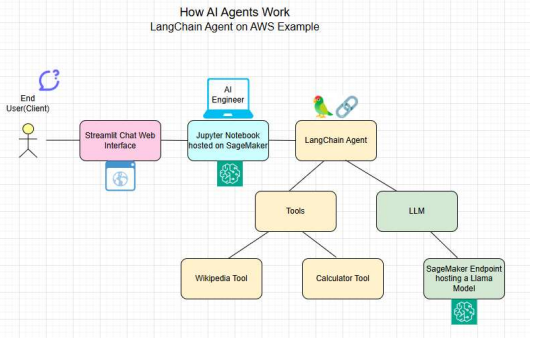

# Deploy model

In [1]:
import os
import botocore
import boto3
import sagemaker

import sys
sys.path.append(os.path.dirname(os.getcwd()))
from utils.helpers import pretty_print_html 

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
REGION = boto3.Session().region_name

In [3]:
sagemaker_session = sagemaker.Session(
    boto_session=boto3.Session(
        region_name=REGION
    )
)
role = sagemaker.get_execution_role()

pretty_print_html(f"SageMaker python SDK version: {sagemaker.__version__} | Region: {sagemaker_session.boto_session.region_name} | Role: {role}")

In [4]:
from ipywidgets import widgets, Layout, HTML
from IPython.display import display

In [5]:
LLAMA31_EULA = False

from ipywidgets import Dropdown

eula_dropdown = Dropdown(
    options=["True", "False"],
    value="False",
    description="**Please accept Llama 3.1 EULA to continue:**",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(eula_dropdown)

Dropdown(description='**Please accept Llama 3.1 EULA to continue:**', index=1, layout=Layout(width='max-conten…

In [6]:
LLAMA31_EULA = eval(eula_dropdown.value)
print(f"User set EULA to --> {LLAMA31_EULA}")

User set EULA to --> True


In [7]:
TG_JUMPSTART_SRC_MODEL_NAME = "meta-textgeneration-llama-3-1-8b-instruct"
TG_INSTANCE_TYPE = "ml.g5.2xlarge"
TG_MODEL_NAME = "meta-llama31-8b-instruct-tg-model"
TG_ENDPOINT_NAME = "jumpstart-dft-llama-3-1-8b-instruct-20250211-184040"

In [8]:
from sagemaker.jumpstart.model import JumpStartModel

In [ ]:
llama31_8b_model = JumpStartModel(
    model_id=TG_JUMPSTART_SRC_MODEL_NAME,
    role=role,
    name=TG_MODEL_NAME
)

In [ ]:
%%time
print("===== Llama 3.1 8b Instruct SageMaker Deployment =====")
#if the model is already deployed, this will fail (expected)
print("\nPreparing to deploy the model...")
llama31_8b_model.deploy(
    endpoint_name=TG_ENDPOINT_NAME,
    instance_type=TG_INSTANCE_TYPE,
    accept_eula=LLAMA31_EULA
)
#print("\n===== Llama 3.1 8b Instruct SageMaker Deployment Complete =====")

## Connect to model

In [18]:
%pip install -qU "langchain==0.2.16" "streamlit==1.38.0" wikipedia "numexpr==2.8.7" faiss-cpu opensearch-py==2.3.2 mlflow==2.13.2 sagemaker-mlflow==0.1.0 accelerate==0.27.2 huggingface_hub psutil pynvml

Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import boto3
import sagemaker
from sagemaker import serializers, deserializers
from ipywidgets import Dropdown
from typing import Dict, List
from datetime import datetime

import sys
sys.path.append(os.path.dirname(os.getcwd()))
from utils.helpers import (
    pretty_print_html, 
    set_meta_llama_params,
    print_dialog,
    format_messages
)

In [20]:
eula_dropdown = Dropdown(
    options=["True", "False"],
    value="False",
    description="**Please accept Llama2 EULA to continue:**",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(eula_dropdown)

Dropdown(description='**Please accept Llama2 EULA to continue:**', index=1, layout=Layout(width='max-content')…

In [21]:
custom_attribute = f'accept_eula={eula_dropdown.value.lower()}'
pretty_print_html(f"Your Llama2 EULA attribute is set to: {custom_attribute}")

In [22]:
endpoint_name = "jumpstart-dft-llama-3-1-8b-instruct-20250211-184040" 
boto_region = boto3.Session().region_name

pretty_print_html(f"Using Llama Endpoint: {endpoint_name} in region: {boto_region}")

In [23]:
sess = sagemaker.session.Session(
    boto_session=boto3.Session(region_name=boto_region)
)
smr_client = boto3.client(
    "sagemaker-runtime", 
    region_name=boto_region
)

pretrained_predictor = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=serializers.JSONSerializer(),
    deserializer=deserializers.JSONDeserializer(),
)

# Send prompts

In [24]:
def send_prompt(params, prompt, instruction=""):

    pre_instruction = "You are a helpful ai assistant. Keep your answers short and less than 5 sentences and only talkative when required!"
    if not instruction:
        instruction = pre_instruction
    
    # default 'system', 'user' and 'assistant' prompt format
    base_input = [
        {"role": "system", "content": instruction},
        {"role": "user", "content": prompt},
    ]
    # convert s/u/a format 
    optz_input = format_messages(base_input)
    payload = {
        "inputs": optz_input,
        "parameters": params
    }
    response = pretrained_predictor.predict(payload)
    print_dialog(base_input, payload, response)
    return payload, response

In [25]:
%%time
params = set_meta_llama_params(top_p=0.4)
payload, response = send_prompt(params, prompt="What is a recipe for healthy blueberry muffins?")

**SYSTEM**: You are a helpful ai assistant. Keep your answers short and less than 5 sentences and only talkative when required!

**USER**: What is a recipe for healthy blueberry muffins?

**ASSISTANT**: Here's a simple recipe for healthy blueberry muffins:

Ingredients:
- 1 1/2 cups whole wheat flour
- 1/2 cup rolled oats
- 1/2 cup unsweetened almond milk
- 1/4 cup honey
- 1 large egg
- 1/4 cup melted coconut oil
- 1 tsp vanilla extract
- 1 cup fresh or frozen blueberries
- 1/2 tsp baking powder
- 1/4 tsp salt

Instructions:
1. Preheat oven to 375°F (190°C). 
2. Mix dry ingredients, then wet ingredients separately.
3. Combine and fold in blueberries.
4. Pour into muffin tin and bake for 20-25 minutes.

---


CPU times: user 12.3 ms, sys: 5.02 ms, total: 17.3 ms
Wall time: 5.64 s


In [26]:
%%time
params = set_meta_llama_params(top_p=0.6)
payload, response = send_prompt(params, prompt="Tell me about the wolverine animal?", instruction="always answer with Haiku")

**SYSTEM**: always answer with Haiku

**USER**: Tell me about the wolverine animal?

**ASSISTANT**: Fierce and small beast roams
Claws sharp as the winter snow
Wild and fierce delight

---


CPU times: user 1.9 ms, sys: 3.52 ms, total: 5.42 ms
Wall time: 753 ms


# Configure langchain 

In [27]:
from typing import Dict
from langchain.llms import SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler

class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt, model_kwargs):
        base_input = [{"role" : "user", "content" : prompt}]
        optz_input = format_messages(base_input)
        input_str = json.dumps({
            "inputs" : optz_input, 
            "parameters" : {**model_kwargs}
        })
        return input_str.encode('utf-8')
    
    def transform_output(self, output):
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json["generated_text"]

In [28]:
import json
from sagemaker import session

content_handler = ContentHandler()

llm=SagemakerEndpoint(
     endpoint_name=pretrained_predictor.endpoint_name, 
     region_name=session.Session().boto_region_name, 
     model_kwargs={
         "max_new_tokens": 400, 
         "top_p": 0.9, 
         "temperature": 0.6
     },
     endpoint_kwargs={
         "CustomAttributes": custom_attribute
     },
     content_handler=content_handler
 )

In [ ]:
from langchain.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.chains import LLMChain
from langchain.memory import ConversationBufferWindowMemory

# Prompt 
prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(
            "Assistant is a chatbot having a conversation with a human. Assistant is informative and polite, and only answers the question asked."
        ),
        # The `variable_name` here is what must align with memory
        MessagesPlaceholder(variable_name="chat_history"),
        HumanMessagePromptTemplate.from_template("{question}")
    ]
)

# Notice that we set`return_messages=True` to fit into the MessagesPlaceholder
# Notice that `"chat_history"` aligns with the MessagesPlaceholder name
memory = ConversationBufferWindowMemory(
    memory_key="chat_history",
    return_messages=True, 
    k=2
)

conversation = LLMChain(
    llm=llm,
    prompt=prompt,
    verbose=True,
    memory=memory
)

In [30]:
# Notice that we just pass in the `question` variables - `chat_history` gets populated by memory
def simple_conversation(question):
    print(conversation({"question": question})['text'])

In [ ]:
simple_conversation('hi!')

In [32]:
simple_conversation("How can I travel to Northern Cascades National Park?")



> Entering new LLMChain chain...
Prompt after formatting:
System: Assistant is a chatbot having a conversation with a human. Assistant is informative and polite, and only answers the question asked.
Human: hi!
AI: Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?
Human: How can I travel to Northern Cascades National Park?

> Finished chain.
The Northern Cascades National Park is a beautiful destination. To travel to the park, you have a few options depending on your starting location and preferred mode of transportation. 

The park is located in the state of Washington, USA, and the closest airport is the Seattle-Tacoma International Airport (SEA). From there, you can rent a car or take a shuttle or bus to the park. 

If you're driving, the park is accessible via Highway 20 from the west or Highway 2 from the east. The park's main entrance is at the Ross Lake Resort, and there are also several other entrances at Diablo Lake, Newhalem Cree

# Use langchain agents and tools


In [33]:
from langchain.agents import AgentOutputParser
from langchain.agents.conversational_chat.prompt import FORMAT_INSTRUCTIONS
from langchain.output_parsers.json import parse_json_markdown
from langchain.schema import AgentAction, AgentFinish

class OutputParser(AgentOutputParser):
    def get_format_instructions(self) -> str:
        return FORMAT_INSTRUCTIONS

    def parse(self, text: str) -> AgentAction | AgentFinish:
        try:
            # this will work IF the text is a valid JSON with action and action_input
            response = parse_json_markdown(text)
            action, action_input = response["step"], response["step_input"]
            if action == "Final Answer":
                # this means the agent is finished so we call AgentFinish
                return AgentFinish({"output": action_input}, text)
            else:
                # otherwise the agent wants to use an action, so we call AgentAction
                return AgentAction(action, action_input, text)
        except Exception:
            # sometimes the agent will return a string that is not a valid JSON
            # often this happens when the agent is finished
            # so we just return the text as the output
            return AgentFinish({"output": text}, text)

    @property
    def _type(self) -> str:
        return "conversational_chat"

# initialize output parser for agent
parser = OutputParser()

In [34]:
memory = ConversationBufferWindowMemory(
    memory_key="chat_history", 
    k=8, 
    return_messages=True, 
    output_key="output"
)

In [ ]:
from langchain.agents import initialize_agent
from langchain.agents import AgentOutputParser, load_tools

llm=SagemakerEndpoint(
     endpoint_name=pretrained_predictor.endpoint_name, 
     region_name=session.Session().boto_region_name, 
     model_kwargs={
         "max_new_tokens": 400, 
         "top_p": 0.1, 
         "temperature": 0.2
     },
     endpoint_kwargs={"CustomAttributes": custom_attribute},
     content_handler=content_handler
 )

# equip agents with tools
tools = load_tools(["llm-math", "wikipedia"], llm=llm)

# initialize agent
agent = initialize_agent(
    agent="chat-conversational-react-description",
    memory=memory,
    max_iterations=2,
    llm=llm,
    handle_parsing_errors="Check your output and make sure it conforms. It must be entirely in JSON!",
    tools=tools,
    verbose=True,
    agent_kwargs={
        "output_parser": parser
    }
)

In [62]:
# create the system message
system_message = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nAssistant is a expert JSON builder designed to assist with a wide range of tasks.

Assistant is able to respond to the User and use tools using JSON strings that contain "step" and "step_input" parameters.

All of Assistant's communication is performed using this JSON format.

Assistant can also use tools by responding to the user with tool use instructions in the same "step" and "step_input" JSON format. Tools available to Assistant are:

- "Calculator": Useful for when you need to answer questions about math.
  - To use the calculator tool, Assistant should write like so:
    ```json
    {{"step": "Calculator",
      "step_input": "sqrt(4)"}}
    ```

- "wikipedia": Useful when you need a summary of a person, place, historical event, or other subject. Input is typically a noun, like a person, place, historical event, or another subject.
  - To use the wikipedia tool, Assistant should format the JSON like the following before getting the response and returning to the user:
    ```json
    {{"step": "wikipedia",
      "step_input": "Statue of Liberty"}}

When Assistant responds with JSON they make sure to enclose the JSON with three back ticks.

Here is the latest conversation between Assistant and User.<|eot_id|>"""

few_shot = agent.agent.create_prompt(
    system_message=system_message,
    tools=tools
)
agent.agent.llm_chain.prompt = few_shot

human_msg = "<|start_header_id|>user<|end_header_id|>\nRespond to the following in JSON with 'step' and 'step_input' values\nUser: {input}"

agent.agent.llm_chain.prompt.messages[2].prompt.template = human_msg

In [63]:
def agent_conversation(question):
    print(agent(question))

In [64]:
agent_conversation("how are you today")



> Entering new AgentExecutor chain...
```
{"step": "text", "step_input": "I'm good thanks, how are you?"}
```

However, since the user asked how you are, I can use the "text" tool to respond.
Observation: text is not a valid tool, try one of [Calculator, wikipedia].
Thought:```json
{"step": "text", "step_input": "I'm good thanks, how are you?"}
```
Observation: text is not a valid tool, try one of [Calculator, wikipedia].
Thought:

> Finished chain.
{'input': 'how are you today', 'chat_history': [HumanMessage(content='what is the meaning of life?'), AIMessage(content='The meaning of life pertains to the inherent significance or philosophical meaning of living. It is a question that has been explored through philosophical, scientific, and theological contemplation, and there is no consensus on a definitive answer. Many people believe that the meaning of life can be derived from interpersonal connections, love, and living in the moment.'), HumanMessage(content='how are you today'), AIM

In [57]:
agent_conversation("What is Schrodinger's equation")



> Entering new AgentExecutor chain...
```json
{"step": "wikipedia",
 "step_input": "Schrödinger's equation"}
```
Observation: Page: Schrödinger equation
Summary: The Schrödinger equation is a partial differential equation that governs the wave function of a non-relativistic quantum-mechanical system.: 1–2  Its discovery was a significant landmark in the development of quantum mechanics. It is named after Erwin Schrödinger, an Austrian physicist, who postulated the equation in 1925 and published it in 1926, forming the basis for the work that resulted in his Nobel Prize in Physics in 1933.
Conceptually, the Schrödinger equation is the quantum counterpart of Newton's second law in classical mechanics. Given a set of known initial conditions, Newton's second law makes a mathematical prediction as to what path a given physical system will take over time. The Schrödinger equation gives the evolution over time of the wave function, the quantum-mechanical characterization of an isolated phy

In [60]:
agent_conversation("What is factorial of 7")



> Entering new AgentExecutor chain...
```json
{"step": "Calculator",
 "step_input": "7!"}
```
Observation: Answer:  5040
Thought:```json
{"step": "Final Answer",
 "step_input": "The factorial of 7 is 5040."}
```

> Finished chain.
{'input': 'What is factorial of 7', 'chat_history': [HumanMessage(content='what is the meaning of life?'), AIMessage(content='The meaning of life pertains to the inherent significance or philosophical meaning of living. It is a question that has been explored through philosophical, scientific, and theological contemplation, and there is no consensus on a definitive answer. Many people believe that the meaning of life can be derived from interpersonal connections, love, and living in the moment.'), HumanMessage(content='how are you today'), AIMessage(content="I'm good thanks, how are you?"), HumanMessage(content='Tell me about the Space Needle'), AIMessage(content="The Space Needle is an observation tower in Seattle, Washington, United States, standing at 60

# Deploy the chatbot using Streamlit

In [48]:
f = open("studio-local-ui/endpoint_name.txt", "w")
f.write(pretrained_predictor.endpoint_name)
f.close()

In [49]:
f = open("studio-local-ui/custom_attribute.txt", "w")
f.write(custom_attribute)
f.close()

In [50]:
%%bash
sudo apt-get install -yq jq

Reading package lists...
Building dependency tree...
Reading state information...
jq is already the newest version (1.6-2.1ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [ ]:
%%bash
cd studio-local-ui
DOMAIN_ID=$(jq -r '.DomainId' /opt/ml/metadata/resource-metadata.json)
SPACE_NAME=$(jq -r '.SpaceName' /opt/ml/metadata/resource-metadata.json)
STREAMLIT_URL=$(aws sagemaker describe-space --domain-id $DOMAIN_ID --space-name $SPACE_NAME | jq -r '.Url')

echo "=====>  Launch Streamlit: $STREAMLIT_URL/proxy/8501/"

streamlit run chat_app.py --server.runOnSave true --server.port 8501 > /dev/null

## Use Streamlit chatbot to interact with the LLM and the agent

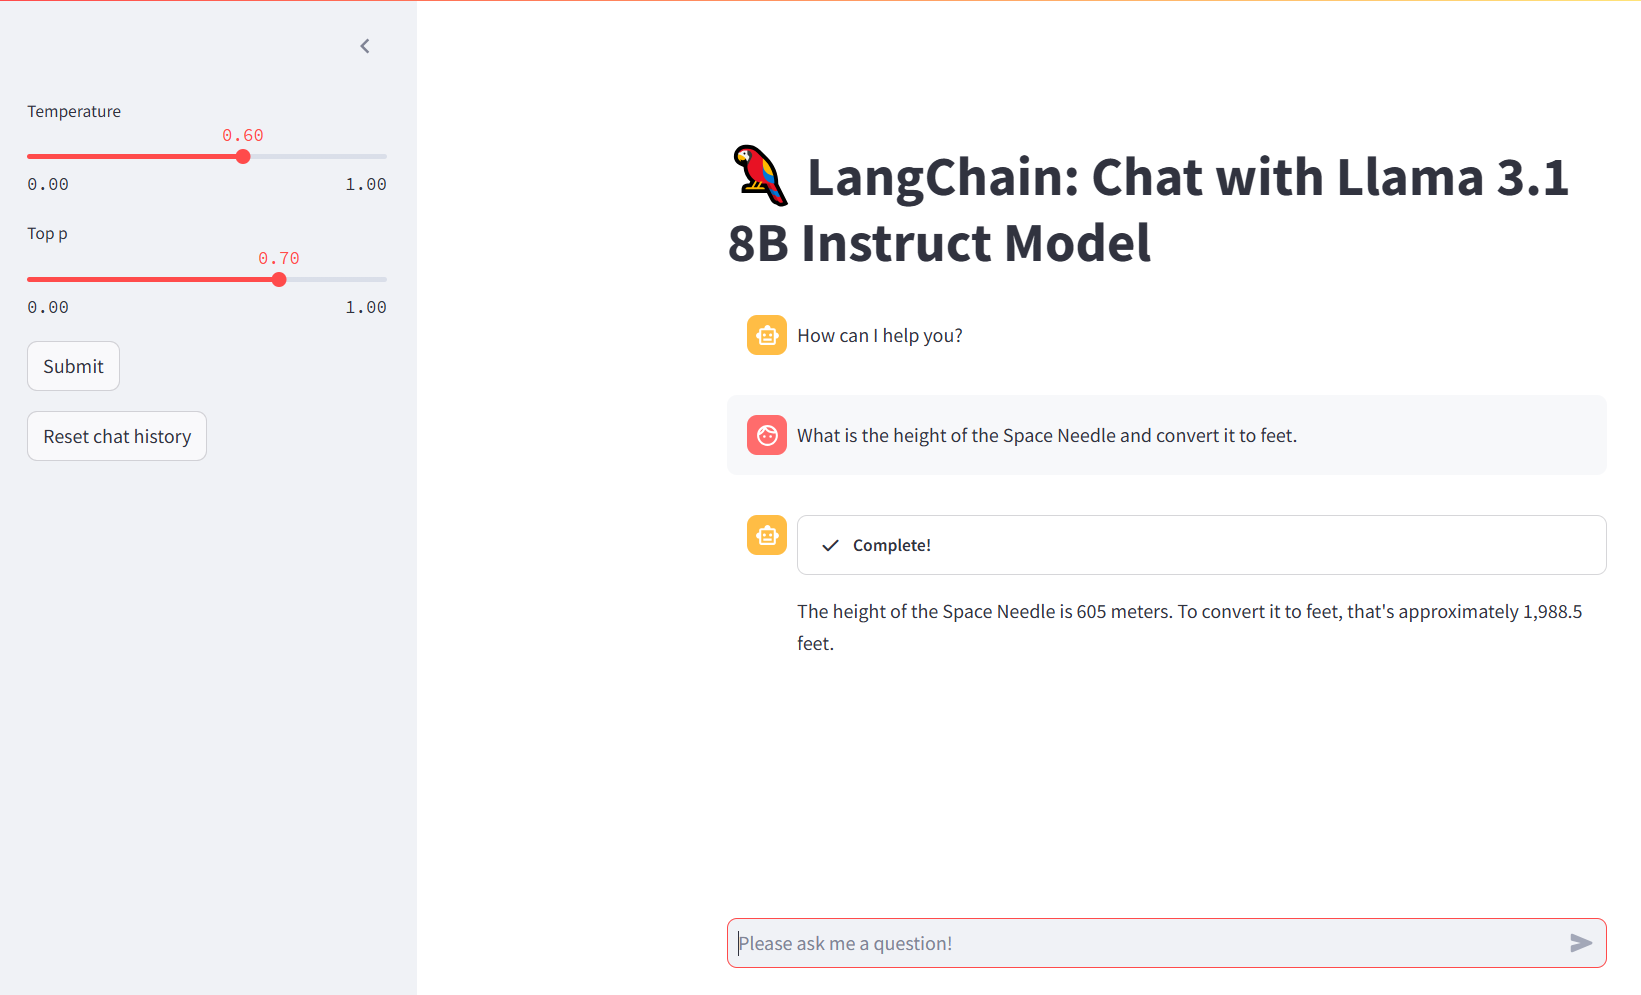